# Import Shtuff

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [7]:
torch.manual_seed(42)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load the Data

In [9]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

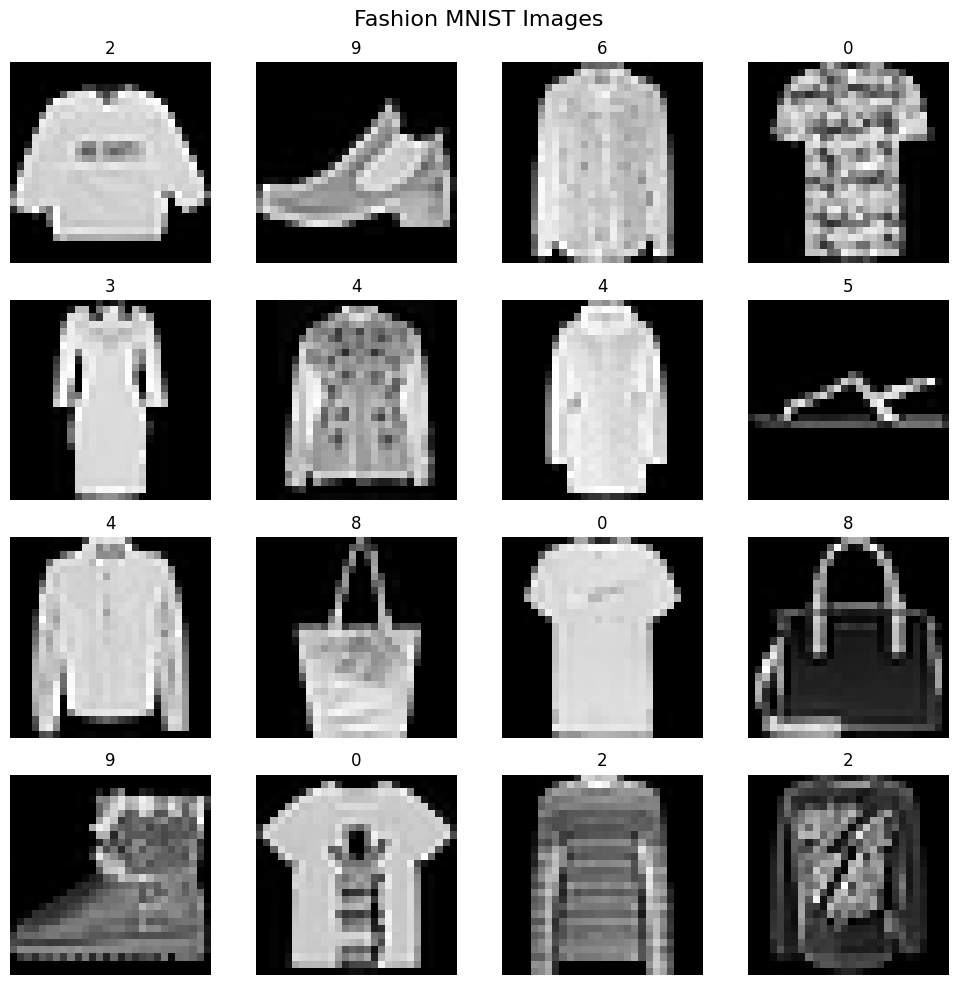

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Fashion MNIST Images', fontsize=16)

for i, ax in enumerate(axs.flat):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='grey')
    ax.axis('off')
    ax.set_title(train_data.iloc[i, 0])

plt.tight_layout()
plt.show()

In [11]:
# seperate data and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [12]:
# normalize the data
X_train = X_train / 255
X_test = X_test / 255

In [13]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [14]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Define the Model

In [16]:
class CNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Define the Hyperparameters

In [31]:
learning_rate = 0.001
epochs = 50

In [32]:
model = CNN(1)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Pipeline

In [33]:
loss_per_epoch = []

for epoch in range(epochs):
    epoch_loss = 0.
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(train_loader)
    loss_per_epoch.append(epoch_loss)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/50, Loss: 0.4353
Epoch 2/50, Loss: 0.2842
Epoch 3/50, Loss: 0.2427
Epoch 4/50, Loss: 0.2178
Epoch 5/50, Loss: 0.1946
Epoch 6/50, Loss: 0.1799
Epoch 7/50, Loss: 0.1648
Epoch 8/50, Loss: 0.1496
Epoch 9/50, Loss: 0.1381
Epoch 10/50, Loss: 0.1291
Epoch 11/50, Loss: 0.1198
Epoch 12/50, Loss: 0.1110
Epoch 13/50, Loss: 0.1074
Epoch 14/50, Loss: 0.0957
Epoch 15/50, Loss: 0.0918
Epoch 16/50, Loss: 0.0883
Epoch 17/50, Loss: 0.0823
Epoch 18/50, Loss: 0.0809
Epoch 19/50, Loss: 0.0777
Epoch 20/50, Loss: 0.0755
Epoch 21/50, Loss: 0.0720
Epoch 22/50, Loss: 0.0713
Epoch 23/50, Loss: 0.0648
Epoch 24/50, Loss: 0.0596
Epoch 25/50, Loss: 0.0608
Epoch 26/50, Loss: 0.0587
Epoch 27/50, Loss: 0.0545
Epoch 28/50, Loss: 0.0539
Epoch 29/50, Loss: 0.0544
Epoch 30/50, Loss: 0.0560
Epoch 31/50, Loss: 0.0488
Epoch 32/50, Loss: 0.0505
Epoch 33/50, Loss: 0.0480
Epoch 34/50, Loss: 0.0491
Epoch 35/50, Loss: 0.0468
Epoch 36/50, Loss: 0.0483
Epoch 37/50, Loss: 0.0451
Epoch 38/50, Loss: 0.0435
Epoch 39/50, Loss: 0.

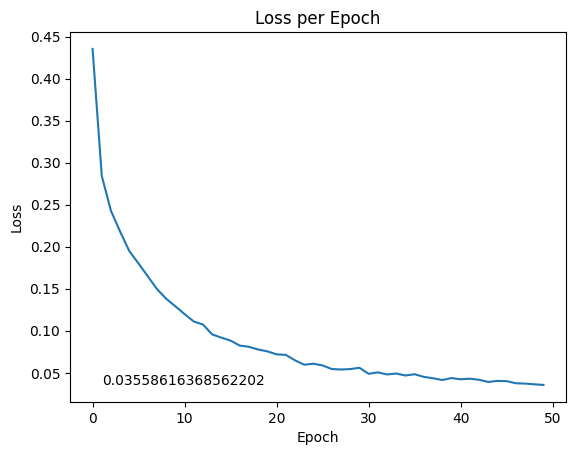

In [34]:
plt.annotate(loss_per_epoch[-1], (1, loss_per_epoch[-1]))
plt.plot(loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

# Model Evaluation

In [35]:
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [36]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs.data, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}%')

Test Accuracy: 0.9268%


In [37]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs.data, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}%')

Test Accuracy: 0.9971%
